# Transformer-Based Analysis of SIF Under Drought Conditions

## Research Objective
    
Drought is a major stressor on ecosystems, particularly for vegetation. Solar-Induced Fluorescence (SIF) serves as a measure of plant photosynthetic activity and thus as an indicator of plant stress. Traditional methods for quantifying drought impact face challenges due to their limited spatial and temporal resolution. <br>

Our analysis investigates how drought related variables - air temperature, precipitation, radiation, surface moisture, evaporation, and transpiration — influence SIF and thus reflect the photosynthetic activity and stress response of vegetation. We employ a transformer encoder-only architecture to analyse the relationships between SIF and the drought-related input variables, surpassing the limitations of conventional drought indices. <br>

The transformer’s ability to incorporate multiple input variables enables a comprehensive analysis of ecosystem responses to diverse extreme events. 
    

## Preprocessing of training and testing data

<span style='background:yellow'>Import the required libraries:</span>

In [1]:
# tensorflow and keras will be imported after the preprocessing is completed (change of Kernel necessary)
import random
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import dask.array as da
import xarray as xr
import zarr
import fsspec
from ml4xcube.preprocessing import normalize, standardize

import matplotlib.pyplot as plt
import folium
import cartopy.crs as ccrs
import cartopy.feature as cfeature

<span style='background:yellow'>Load Earth System Data Cube [@Mahecha2020]:</span>

In [2]:
# Open Earth System Data Cube (Version 3.0.2) and load data in dataset
ds = xr.open_dataset("http://data.rsc4earth.de/EarthSystemDataCube/v3.0.2/esdc-8d-0.25deg-256x128x128-3.0.2.zarr/", chunks={}, engine="zarr")

# dataset details
# ds

In [3]:
# Define lat, lon ranges for Europe
lat_range = slice(35, 71)  # Lat range Europe
lon_range = slice(-25, 45)  # Lon range Europe

# for testing: chose only Germany to save computational resources 
# lat_range = slice(47.270, 55.055)
# lon_range = slice(5.866, 15.041)

# Define the time slice
time_start = '2019-01-01'  # Start of time range (value of year is sufficient, e.g. '2010')
time_end = '2021-12-31'    # End of time range (value of year is sufficient, e.g. '2020')

# Extract data for Europe
ds_europe = ds.sel(lat=lat_range, lon=lon_range, time=slice(time_start, time_end))

# Extract relevant variables
variables = ['air_temperature_2m', 'precipitation_era5', 'radiation_era5', 'surface_moisture' ,'evaporation', 'transpiration', 'sif_gosif'] 
ds_europe_variables = ds_europe[variables]

# ds_europe_variables.to_netcdf("ds_slice_europe.nc")
ds_europe_variables

<xarray.Dataset> Size: 156MB
Dimensions:             (time: 138, lat: 144, lon: 280)
Coordinates:
  * lat                 (lat) float64 1kB 35.12 35.38 35.62 ... 70.62 70.88
  * lon                 (lon) float64 2kB -24.88 -24.62 -24.38 ... 44.62 44.88
  * time                (time) datetime64[ns] 1kB 2019-01-05 ... 2021-12-31
Data variables:
    air_temperature_2m  (time, lat, lon) float32 22MB dask.array<chunksize=(138, 12, 20), meta=np.ndarray>
    precipitation_era5  (time, lat, lon) float32 22MB dask.array<chunksize=(138, 12, 20), meta=np.ndarray>
    radiation_era5      (time, lat, lon) float32 22MB dask.array<chunksize=(138, 12, 20), meta=np.ndarray>
    surface_moisture    (time, lat, lon) float32 22MB dask.array<chunksize=(138, 12, 20), meta=np.ndarray>
    evaporation         (time, lat, lon) float32 22MB dask.array<chunksize=(138, 12, 20), meta=np.ndarray>
    transpiration       (time, lat, lon) float32 22MB dask.array<chunksize=(138, 12, 20), meta=np.ndarray>
    sif_gosif           (time, lat, lon) float32 22MB dask.array<chunksize=(138, 12, 20), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

<span style='background:yellow'>Plot mean SIF over time:</span>

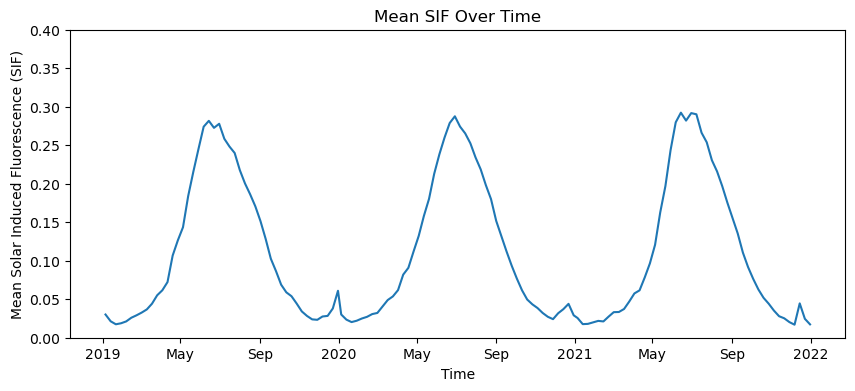

In [4]:
# Calculate the mean SIF over time
mean_sif_over_time = ds_europe_variables['sif_gosif'].mean(dim=['lat', 'lon'], skipna=True)

# Plot the mean SIF over time
plt.figure(figsize=(10, 4))
mean_sif_over_time.plot()
plt.xlabel('Time')
plt.ylabel('Mean Solar Induced Fluorescence (SIF)')
plt.ylim(0,0.4)
plt.title('Mean SIF Over Time')
plt.show()

<span style='background:yellow'>To later on simulate SIF during 2018 drought in Germany, extract (normalised) mean values for each variable of July 2018</span>

In [5]:
def compute_min_max(ds: xr.Dataset) -> Dict[str, List[float]]:
    """
    Compute the min and max values for each variable in the dataset.
    
    Args:
        ds (xr.Dataset): The dataset to compute min and max values for.

    Returns:
        Dict[str, List[float]]: A dictionary with variable names as keys and [min, max] as values.
    """
    min_max_dict = {}
    for var in ds.data_vars:
        min_val = ds[var].min().values.item()
        max_val = ds[var].max().values.item()
        min_max_dict[var] = [min_val, max_val]
    return min_max_dict

def normalize(data, min_val, max_val):
    """
    Normalize data using min and max values.
    
    Args:
        data (float): The data to normalize.
        min_val (float): The minimum value for normalization.
        max_val (float): The maximum value for normalization.

    Returns:
        float: The normalized data.
    """
    return (data - min_val) / (max_val - min_val)

# Define the latitude and longitude range for Germany
lat_range = slice(47.270, 55.055)
lon_range = slice(5.866, 15.041)

# Define the time slice for the entire year 2018
time_start = '2018-01-01'
time_end = '2018-12-31'

# Extract data for Germany for the year 2018
ds_germany = ds.sel(lat=lat_range, lon=lon_range, time=slice(time_start, time_end))

# Define the variables of interest
variables = ['air_temperature_2m', 'precipitation_era5', 'radiation_era5', 'evaporation', 'surface_moisture', 'transpiration', 'sif_gosif']

# Extract the relevant variables
ds_germany_slice = ds_germany[variables]

# Define the time slice for July 2018
time_july = slice('2018-07-01', '2018-07-31')

# Extract data for July 2018
ds_germany_july = ds_germany_slice.sel(time=time_july)

# Compute the mean for July 2018 over Germany for each variable
mean_july_2018 = ds_germany_july.mean(dim=['lat', 'lon', 'time'], skipna=True)

# Print the mean values for July 2018 for each variable
print("Mean values for July 2018 in Germany:")
mean_values_july_2018 = {}
for variable in variables:
    mean_value = mean_july_2018[variable].values
    mean_values_july_2018[variable] = mean_value
    print(f"{variable}: {mean_value}")

# Compute min and max values from the dataset for Germany in 2018
combined_min_max = compute_min_max(ds_germany_slice)

# Normalize the mean values for July 2018 using the min-max values
normalized_mean_values_july_2018 = {var: normalize(mean_values_july_2018[var], combined_min_max[var][0], combined_min_max[var][1]) for var in variables}

# Print the normalized mean values for July 2018
print("\nNormalized mean values for July 2018 in Germany:")
for variable in variables:
    print(f"{variable}: {normalized_mean_values_july_2018[variable]}")

Mean values for July 2018 in Germany:
air_temperature_2m: 19.824729919433594
precipitation_era5: 1.5844333171844482
radiation_era5: 769855.9375
evaporation: 2.9175705909729004
surface_moisture: 0.28580617904663086
transpiration: 2.4064269065856934
sif_gosif: 0.28136083483695984

Normalized mean values for July 2018 in Germany:
air_temperature_2m: 0.8101357677984857
precipitation_era5: 0.09217376515411849
radiation_era5: 0.686266861634277
evaporation: 0.43960238037652755
surface_moisture: 0.40022046308959586
transpiration: 0.661117381373725
sif_gosif: 0.47830269266898034


<span style='background:yellow'>Split data into test and training dataset</span>

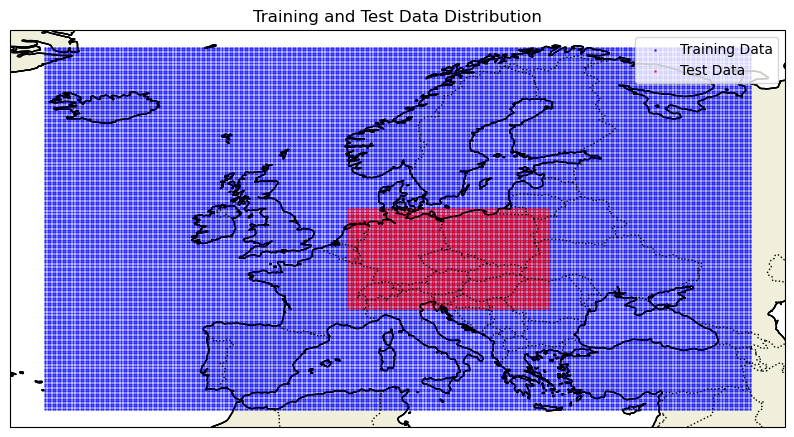

In [6]:
# ds_europe_variables = xr.open_dataset('ds_europe_variables.nc')

# Define the test box
test_lat_range = slice(45, 55)
test_lon_range = slice(5, 25)

# Split the dataset
ds_test = ds_europe_variables.sel(lat=test_lat_range, lon=test_lon_range)
ds_train = ds_europe_variables.where(
    ~((ds_europe_variables.lat >= test_lat_range.start) & (ds_europe_variables.lat <= test_lat_range.stop) & 
      (ds_europe_variables.lon >= test_lon_range.start) & (ds_europe_variables.lon <= test_lon_range.stop)),
    drop=True
)

# Plotting training and test data on map
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

# Plot training data points
train_lats, train_lons = np.meshgrid(ds_train['lat'], ds_train['lon'], indexing='ij')
ax.scatter(train_lons, train_lats, color='blue', label='Training Data', s=1, alpha=0.6)

# Plot test data points
test_lats, test_lons = np.meshgrid(ds_test['lat'], ds_test['lon'], indexing='ij')
ax.scatter(test_lons, test_lats, color='red', label='Test Data', s=1, alpha=0.6)

# Add features to the plot
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='none', edgecolor='black')
# ax.set_extent([-25, 45, 35, 71], crs=ccrs.PlateCarree())
ax.legend()

# Add title and labels
plt.title('Training and Test Data Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()


In [7]:
# Look up dimensions of train and test ds
# ds_test # time: 138, lat: 40, lon: 80 -> lat * lon = No of Grid cells = 3200
# ds_train # time: 138, lat: 144, lon: 280 -> lat * lon = No of Grid cells = 40320

<span style='background:yellow'>Normalise both datasets</span>

In [8]:
def compute_min_max(ds: xr.Dataset) -> Dict[str, List[float]]:
    """
    Compute the min and max values for each variable in the dataset.
    
    Args:
        ds (xr.Dataset): The dataset to compute min and max values for.

    Returns:
        Dict[str, List[float]]: A dictionary with variable names as keys and [min, max] as values.
    """
    min_max_dict = {}
    for var in ds.data_vars:
        min_val = ds[var].min().values.item()
        max_val = ds[var].max().values.item()
        min_max_dict[var] = [min_val, max_val]
    return min_max_dict

def normalize_dataset(ds: xr.Dataset, min_max_dict: Dict[str, List[float]]) -> xr.Dataset:
    """
    Normalize the dataset using the provided min and max values for each variable.
    
    Args:
        ds (xr.Dataset): The dataset to normalize.
        min_max_dict (Dict[str, List[float]]): The dictionary containing min and max values for each variable.

    Returns:
        xr.Dataset: The normalized dataset.
    """
    ds_normalized = ds.copy()
    for var in ds.data_vars:
        if var in min_max_dict:
            min_val, max_val = min_max_dict[var]
            ds_normalized[var] = normalize(ds[var], min_val, max_val)
    return ds_normalized

# Combine ds_test and ds_train to compute the global min and max values
combined_ds = xr.concat([ds_test, ds_train], dim='time')

# Compute min and max values from the combined dataset
combined_min_max = compute_min_max(combined_ds)

# Normalize the test and train datasets
test_ds_normalized = normalize_dataset(ds_test, combined_min_max)
train_ds_normalized = normalize_dataset(ds_train, combined_min_max)

# Display normalized datasets for verification
print("Normalized Test Dataset:")
print(test_ds_normalized)

print("Normalized Train Dataset:")
print(train_ds_normalized)


Normalized Test Dataset:
<xarray.Dataset> Size: 12MB
Dimensions:             (time: 138, lat: 40, lon: 80)
Coordinates:
  * lat                 (lat) float64 320B 45.12 45.38 45.62 ... 54.62 54.88
  * lon                 (lon) float64 640B 5.125 5.375 5.625 ... 24.62 24.88
  * time                (time) datetime64[ns] 1kB 2019-01-05 ... 2021-12-31
Data variables:
    air_temperature_2m  (time, lat, lon) float32 2MB dask.array<chunksize=(138, 40, 28), meta=np.ndarray>
    precipitation_era5  (time, lat, lon) float32 2MB dask.array<chunksize=(138, 40, 28), meta=np.ndarray>
    radiation_era5      (time, lat, lon) float32 2MB dask.array<chunksize=(138, 40, 28), meta=np.ndarray>
    surface_moisture    (time, lat, lon) float32 2MB dask.array<chunksize=(138, 40, 28), meta=np.ndarray>
    evaporation         (time, lat, lon) float32 2MB dask.array<chunksize=(138, 40, 28), meta=np.ndarray>
    transpiration       (time, lat, lon) float32 2MB dask.array<chunksize=(138, 40, 28), meta=np.ndarray

<span style='background:yellow'>Create dataframe of all unique coordinates with NaN values (for testing and training data)</span>

In [9]:
# Define specific time step
time_step = '2021-11-13' # You can test out other time steps to check whether nan values differ over time dimension, '2019-03-10'

# Define variables to process
variables = ['air_temperature_2m', 'precipitation_era5', 'radiation_era5', 'sif_gosif', 'surface_moisture', 'evaporation', 'transpiration']

# Function to find NaN coordinates in dataset for given variables at specific time step
def find_nan_coordinates(ds, time_step, variables):
    coordinates_dfs = {}
    unique_coords = set()
    
    for variable in variables:
        # Select data for the specific time step
        data = ds[variable].sel(time=time_step)
        
        # Find the coordinates where the variable is NaN
        coords = np.where(np.isnan(data))
        
        # Convert coordinates to latitude and longitude
        latitudes = data.coords['lat'][coords[0]].values
        longitudes = data.coords['lon'][coords[1]].values
        
        # Create a DataFrame for the current variable
        coordinates_df = pd.DataFrame({
            'lat': latitudes,
            'lon': longitudes
        })
        
        # Store the dataframe in the dictionary
        coordinates_dfs[f'coordinates_{variable}_nans_df'] = coordinates_df
        
        # Add the coordinates to the set of unique coordinates
        unique_coords.update(zip(latitudes, longitudes))
    
    # Convert the set of unique coordinates to a DataFrame
    coordinates_any_nans_df = pd.DataFrame(list(unique_coords), columns=['lat', 'lon'])
    
    return coordinates_dfs, coordinates_any_nans_df

# Process test and train datasets
test_coordinates_dfs, test_coordinates_any_nans_df = find_nan_coordinates(test_ds_normalized, time_step, variables)
train_coordinates_dfs, train_coordinates_any_nans_df = find_nan_coordinates(train_ds_normalized, time_step, variables)

# Output the dataframes for the test dataset
coordinates_sif_nans_df_test = test_coordinates_dfs['coordinates_sif_gosif_nans_df']
coordinates_surface_moisture_nans_df_test = test_coordinates_dfs['coordinates_surface_moisture_nans_df']
coordinates_evaporation_nans_df_test = test_coordinates_dfs['coordinates_evaporation_nans_df']
coordinates_transpiration_nans_df_test = test_coordinates_dfs['coordinates_transpiration_nans_df']

# Output the dataframes for the train dataset
coordinates_sif_nans_df_train = train_coordinates_dfs['coordinates_sif_gosif_nans_df']
coordinates_surface_moisture_nans_df_train = train_coordinates_dfs['coordinates_surface_moisture_nans_df']
coordinates_evaporation_nans_df_train = train_coordinates_dfs['coordinates_evaporation_nans_df']
coordinates_transpiration_nans_df_train = train_coordinates_dfs['coordinates_transpiration_nans_df']

# Print dataframes to verify
# print("Test Dataset:")
#print("Coordinates with NaNs for sif_gosif:")
#print(coordinates_sif_nans_df_test.head())
#print("\nCoordinates with NaNs for surface_moisture:")
#print(coordinates_surface_moisture_nans_df_test.head())
#print("\nCoordinates with NaNs for evaporation:")
#print(coordinates_evaporation_nans_df_test.head())
#print("\nCoordinates with NaNs for transpiration:")
#print(coordinates_transpiration_nans_df_test.head())
# print("\nAll unique coordinates with NaNs in Test Dataset:")
# print(test_coordinates_any_nans_df.head())
# test_coordinates_any_nans_df # 197 rows

# print("\nTrain Dataset:")
#print("Coordinates with NaNs for sif_gosif:")
#print(coordinates_sif_nans_df_train.head())
#print("\nCoordinates with NaNs for surface_moisture:")
#print(coordinates_surface_moisture_nans_df_train.head())
#print("\nCoordinates with NaNs for evaporation:")
#print(coordinates_evaporation_nans_df_train.head())
#print("\nCoordinates with NaNs for transpiration:")
#print(coordinates_transpiration_nans_df_train.head())
#print("\nAll unique coordinates with NaNs in Train Dataset:")
# print(train_coordinates_any_nans_df.head())

train_coordinates_any_nans_df # 23785 rows (note the number of rows to compute new BATCH_SIZE_TRAIN)
# test_coordinates_any_nans_df # 197 rows (note the number of rows to compute new BATCH_SIZE_TEST)

,lat,lon
0,39.875,15.125
1,39.875,15.375
2,39.875,15.625
3,63.625,-10.875
4,63.625,-10.625
...,...,...
23780,50.375,-24.125
23781,52.375,22.125
23782,52.375,22.375
23783,52.375,22.625


<span style='background:yellow'>Plot of coordinates that contain NaN values (for testing and training data)</span>

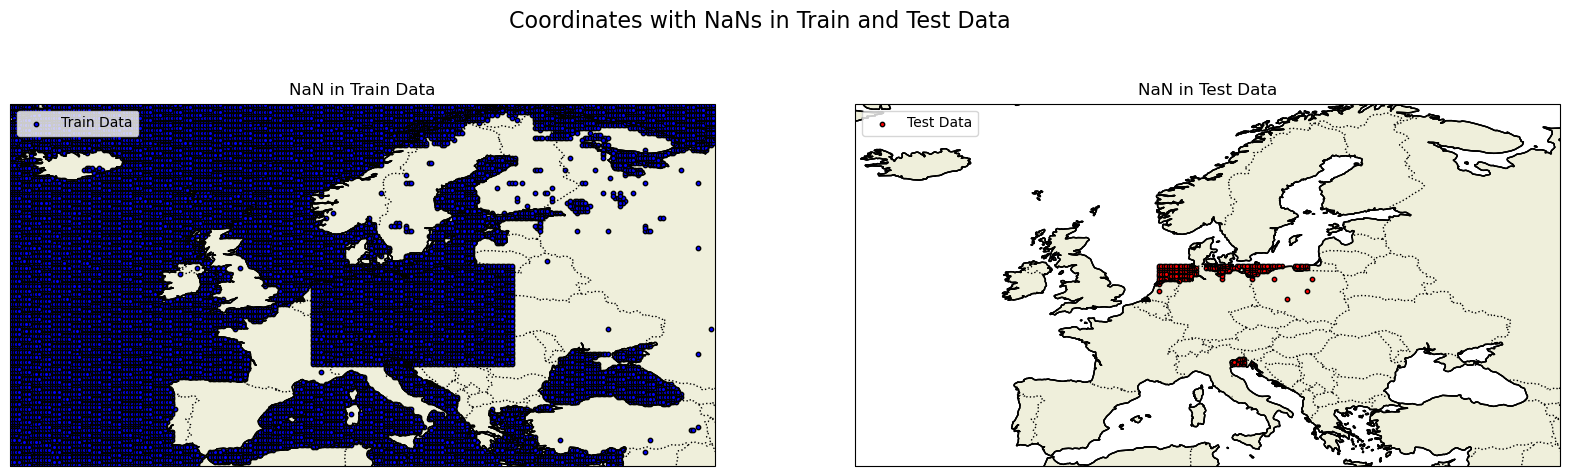

In [10]:
def plot_nan_coordinates(train_df, test_df):
    # Create a figure with two subplots (left: train, right: test)
    fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot train data on the left subplot
    ax_train.scatter(train_df['lon'], train_df['lat'], color='blue', marker='o', s=10, edgecolor='k', label='Train Data')
    ax_train.set_title('NaN in Train Data')
    ax_train.add_feature(cfeature.COASTLINE)
    ax_train.add_feature(cfeature.BORDERS, linestyle=':')
    ax_train.add_feature(cfeature.LAND, edgecolor='black')
    ax_train.add_feature(cfeature.OCEAN, facecolor='none', edgecolor='black')
    ax_train.set_extent([-25, 45, 35, 71], crs=ccrs.PlateCarree())

    # Plot test data on the right subplot
    ax_test.scatter(test_df['lon'], test_df['lat'], color='red', marker='o', s=10, edgecolor='k', label='Test Data')
    ax_test.set_title('NaN in Test Data')
    ax_test.add_feature(cfeature.COASTLINE)
    ax_test.add_feature(cfeature.BORDERS, linestyle=':')
    ax_test.add_feature(cfeature.LAND, edgecolor='black')
    ax_test.add_feature(cfeature.OCEAN, facecolor='none', edgecolor='black')
    ax_test.set_extent([-25, 45, 35, 71], crs=ccrs.PlateCarree())

    # Add legends
    ax_train.legend(loc='upper left')
    ax_test.legend(loc='upper left')

    # Add titles and labels
    fig.suptitle('Coordinates with NaNs in Train and Test Data', fontsize=16)
    ax_train.set_xlabel('Longitude')
    ax_train.set_ylabel('Latitude')
    ax_test.set_xlabel('Longitude')
    ax_test.set_ylabel('Latitude')
    
    # Adjust spacing
    fig.subplots_adjust(top=1.3)

    # Show plot
    plt.show()

plot_nan_coordinates(train_coordinates_any_nans_df, test_coordinates_any_nans_df)


<span style='background:yellow'>Conver dataset to pandas dataframe to drop coordinates that contain NaN values</span>

In [11]:
# Convert sliced dataset to dataframe to clean data with pandas
df_train = train_ds_normalized.to_dataframe()

df_test = test_ds_normalized.to_dataframe()

In [12]:
# Convert train_coordinates_any_nans_df to a set of tuples (lat, lon)
coords_to_remove = set(train_coordinates_any_nans_df[['lat', 'lon']].itertuples(index=False, name=None))

# Function to check if row should be removed based on its lat and lon
def should_remove(row):
    return (row.name[1], row.name[2]) in coords_to_remove

# Apply filtering function
df_train_no_nans = df_train[~df_train.apply(should_remove, axis=1)]

# Print shape of df_train before and after deletion
print("df_train shape:", df_train.shape)

print("Filtered df_train_no_nans shape:", df_train_no_nans.shape)

# Save the filtered DataFrame to CSV file
output_file_path = 'df_train_no_nans.csv'
df_train_no_nans.to_csv(output_file_path, index=False)

df_train shape: (5564160, 7)
Filtered df_train_no_nans shape: (2281830, 7)


In [13]:
# Convert test_coordinates_any_nans_df to a set of tuples (lat, lon)
coords_to_remove = set(test_coordinates_any_nans_df[['lat', 'lon']].itertuples(index=False, name=None))

# Function to check if row should be removed based on its lat and lon
def should_remove(row):
    return (row.name[1], row.name[2]) in coords_to_remove

# Apply filtering function
df_test_no_nans = df_test[~df_test.apply(should_remove, axis=1)]

# Print shape of df_test before and after deletion
print("df_test shape:", df_test.shape)

print("Filtered df_test_no_nans shape:", df_test_no_nans.shape)

# Save the filtered DataFrame to CSV file
output_file_path = 'df_test_no_nans.csv'
df_test_no_nans.to_csv(output_file_path, index=False)

df_test shape: (441600, 7)
Filtered df_test_no_nans shape: (414414, 7)


<span style='background:yellow'>Count number of NaN values in the previous and cleaned df to verify that NaNs got dropped</span>


In [14]:
# Count NaNs in the original DataFrame (df_train)
# Count the number of NaN values in each column
nan_count_per_column_before = df_train.isna().sum()

# Print the number of NaN values per column before cleaning
print("Original df_train - Number of NaN values in each column:")
print(nan_count_per_column_before)

# Count the total number of NaN values in the original dataframe
total_nan_count_before = df_train.isna().sum().sum()

# Print the total number of NaN values before cleaning
print("\nOriginal df_train - Total number of NaN values in the dataframe:")
print(total_nan_count_before)

# Count NaNs in the cleaned DataFrame (df_train_no_nans)
# Count the number of NaN values in each column
nan_count_per_column_after = df_train_no_nans.isna().sum()

# Print the number of NaN values per column after cleaning
print("\nCleaned df_train_no_nans - Number of NaN values in each column:")
print(nan_count_per_column_after)

# Count the total number of NaN values in the cleaned dataframe
total_nan_count_after = df_train_no_nans.isna().sum().sum()

# Print the total number of NaN values after cleaning
print("\nCleaned df_train_no_nans - Total number of NaN values in the dataframe:")
print(total_nan_count_after)


Original df_train - Number of NaN values in each column:
air_temperature_2m     441600
precipitation_era5     441600
radiation_era5         441600
surface_moisture      3257766
evaporation           3110327
transpiration         3199932
sif_gosif             3087612
dtype: int64

Original df_train - Total number of NaN values in the dataframe:
13980437

Cleaned df_train_no_nans - Number of NaN values in each column:
air_temperature_2m    0
precipitation_era5    0
radiation_era5        0
surface_moisture      0
evaporation           0
transpiration         0
sif_gosif             0
dtype: int64

Cleaned df_train_no_nans - Total number of NaN values in the dataframe:
0


In [15]:
# Count NaNs in the original DataFrame (df_test)
# Count the number of NaN values in each column
nan_count_per_column_before = df_test.isna().sum()

# Print the number of NaN values per column before cleaning
print("Original df_test - Number of NaN values in each column:")
print(nan_count_per_column_before)

# Count the total number of NaN values in the original dataframe
total_nan_count_before = df_test.isna().sum().sum()

# Print the total number of NaN values before cleaning
print("\nOriginal df_test - Total number of NaN values in the dataframe:")
print(total_nan_count_before)

# Count NaNs in the cleaned DataFrame (df_test_no_nans)
# Count the number of NaN values in each column
nan_count_per_column_after = df_test_no_nans.isna().sum()

# Print the number of NaN values per column after cleaning
print("\nCleaned df_test_no_nans - Number of NaN values in each column:")
print(nan_count_per_column_after)

# Count the total number of NaN values in the cleaned dataframe
total_nan_count_after = df_test_no_nans.isna().sum().sum()

# Print the total number of NaN values after cleaning
print("\nCleaned df_test_no_nans - Total number of NaN values in the dataframe:")
print(total_nan_count_after)


Original df_test - Number of NaN values in each column:
air_temperature_2m        0
precipitation_era5        0
radiation_era5            0
surface_moisture      26634
evaporation           23736
transpiration         26634
sif_gosif             20562
dtype: int64

Original df_test - Total number of NaN values in the dataframe:
97566

Cleaned df_test_no_nans - Number of NaN values in each column:
air_temperature_2m    0
precipitation_era5    0
radiation_era5        0
surface_moisture      0
evaporation           0
transpiration         0
sif_gosif             0
dtype: int64

Cleaned df_test_no_nans - Total number of NaN values in the dataframe:
0


<span style='background:yellow'>Split cleaned dataframes into input (drought related variables) and output (SIF)</span>

In [16]:
# Reset the index and set the new index to 'time', 'lat', 'lon'
df_train_no_nans = df_train_no_nans.reset_index().set_index(['time', 'lat', 'lon'])

# Define input variables and output variable
input_vars = ['air_temperature_2m', 'precipitation_era5', 'surface_moisture', 'radiation_era5', 'evaporation', 'transpiration']
output_var = 'sif_gosif'

# Extract input and output dataframes
input_train_df = df_train_no_nans[input_vars]
output_train_df = df_train_no_nans[[output_var]]

# Convert to NumPy arrays
input_train_data = input_train_df.values
output_train_data = output_train_df.values

# Check the type and shape of input and output data
print("Type of input_train_data:", type(input_train_data))
print("Shape of input_train_data:", input_train_data.shape)
print("Type of output_train_data:", type(output_train_data))
print("Shape of output_train_data:", output_train_data.shape)


Type of input_train_data: <class 'numpy.ndarray'>
Shape of input_train_data: (2281830, 6)
Type of output_train_data: <class 'numpy.ndarray'>
Shape of output_train_data: (2281830, 1)


In [17]:
# Reset the index and set the new index to 'time', 'lat', 'lon'
df_test_no_nans = df_test_no_nans.reset_index().set_index(['time', 'lat', 'lon'])

# Define input variables and output variable (using the same variables as for training)
input_vars = ['air_temperature_2m', 'precipitation_era5', 'surface_moisture', 'radiation_era5', 'evaporation', 'transpiration']
output_var = 'sif_gosif'

# Extract input and output dataframes
input_test_df = df_test_no_nans[input_vars]
output_test_df = df_test_no_nans[[output_var]]

# Convert to NumPy arrays
input_test_data = input_test_df.values
output_test_data = output_test_df.values

# Check the type and shape of input and output data
print("Type of input_test_data:", type(input_test_data))
print("Shape of input_test_data:", input_test_data.shape)
print("Type of output_test_data:", type(output_test_data))
print("Shape of output_test_data:", output_test_data.shape)


Type of input_test_data: <class 'numpy.ndarray'>
Shape of input_test_data: (414414, 6)
Type of output_test_data: <class 'numpy.ndarray'>
Shape of output_test_data: (414414, 1)


<span style='background:yellow'>Save preprocessed input and output numpy array</span>

- SIF: Target variable (OUTPUT)

- Drought-related variables: Features (INPUT)

In [18]:
# Define context window, feature length, and batch size for training
CONTEXT_WINDOW = 138  # Length of the input sequences (e.g., time steps)
FEATURES_LENGTH = 6  # Number of features per time step
BATCH_SIZE_TRAIN = 16535  # Adjusted batch size for testing (lat * lon from original ds - number of rows NaN df)

# Calculate total number of elements
total_input_elements_train = input_train_data.size
total_output_elements_train = output_train_data.size

# Verify dimensions match
if total_input_elements_train != BATCH_SIZE_TRAIN * CONTEXT_WINDOW * FEATURES_LENGTH:
    raise ValueError("Total number of elements in input_train_data does not match the expected shape.")
if total_output_elements_train != BATCH_SIZE_TRAIN * CONTEXT_WINDOW:
    raise ValueError("Total number of elements in output_train_data does not match the expected shape.")

# Reshape input data
INPUT_TRAIN = input_train_data.reshape((BATCH_SIZE_TRAIN, CONTEXT_WINDOW, FEATURES_LENGTH))

# Reshape output data
OUTPUT_TRAIN = output_train_data.reshape((BATCH_SIZE_TRAIN, CONTEXT_WINDOW))

# Print the shapes
print("Shape of INPUT_TRAIN:", INPUT_TRAIN.shape)  # Should be (BATCH_SIZE_TRAIN, CONTEXT_WINDOW, FEATURES_LENGTH)
print("Shape of OUTPUT_TRAIN:", OUTPUT_TRAIN.shape)  # Should be (BATCH_SIZE_TRAIN, CONTEXT_WINDOW)

# Save input_train_data
np.save('input_train_data.npy', INPUT_TRAIN)

# Save output_train_data
np.save('output_train_data.npy', OUTPUT_TRAIN)


Shape of INPUT_TRAIN: (16535, 138, 6)
Shape of OUTPUT_TRAIN: (16535, 138)


In [19]:
# Define context window, feature length, and batch size for testing
CONTEXT_WINDOW = 138  # Length of the input sequences (e.g., time steps)
FEATURES_LENGTH = 6  # Number of features per time step
BATCH_SIZE_TEST = 3003  # Adjusted batch size for testing (lat * lon from original ds - number of rows NaN df)

# Calculate total number of elements
total_input_elements_test = input_test_data.size
total_output_elements_test = output_test_data.size

# Verify dimensions match
if total_input_elements_test != BATCH_SIZE_TEST * CONTEXT_WINDOW * FEATURES_LENGTH:
    raise ValueError("Total number of elements in input_test_data does not match the expected shape.")
if total_output_elements_test != BATCH_SIZE_TEST * CONTEXT_WINDOW:
    raise ValueError("Total number of elements in output_test_data does not match the expected shape.")

# Reshape input data
INPUT_TEST = input_test_data.reshape((BATCH_SIZE_TEST, CONTEXT_WINDOW, FEATURES_LENGTH))

# Reshape output data
OUTPUT_TEST = output_test_data.reshape((BATCH_SIZE_TEST, CONTEXT_WINDOW))

# Print the shapes
print("Shape of INPUT_TEST:", INPUT_TEST.shape)  # Should be (BATCH_SIZE_TEST, CONTEXT_WINDOW, FEATURES_LENGTH)
print("Shape of OUTPUT_TEST:", OUTPUT_TEST.shape)  # Should be (BATCH_SIZE_TEST, CONTEXT_WINDOW)

# Save input_test_data
np.save('input_test_data.npy', INPUT_TEST)

# Save output_test_data
np.save('output_test_data.npy', OUTPUT_TEST)


Shape of INPUT_TEST: (3003, 138, 6)
Shape of OUTPUT_TEST: (3003, 138)
